# **Credit Card Payment Classification Using Pipeline**


## The objective is to predict whether or not a credit card client will default for their payment in the next month. We will be using the better of 2 classifiers namely, Random Forest and KNN Classifier, and determine the best of a given set of hyperparameters by using grid search.


In [ ]:
## Use this for consistency in graphs through out the notebook
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [ ]:
## Load the data

df = pd.read_excel("/content/default of credit card clients.xls", skiprows= 1, header = 0, index_col=0)

In [ ]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
import seaborn as sns
import plotly.express as px
from IPython.display import display

# 1. Data exploration:

In [ ]:
# dulipcate the dataset
df_explore = df.copy()

In [ ]:
# Move column "default payment next month" to the first column
columns = df_explore.columns.tolist()
columns = [columns[-1]] + columns[:-1]
df_explore = df_explore[columns]
df_explore.head()

,default payment next month,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
1,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
2,1,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,0,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,0,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [ ]:
# See the info of dataset and check if there is missing data --> No missing data
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   default payment next month  30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

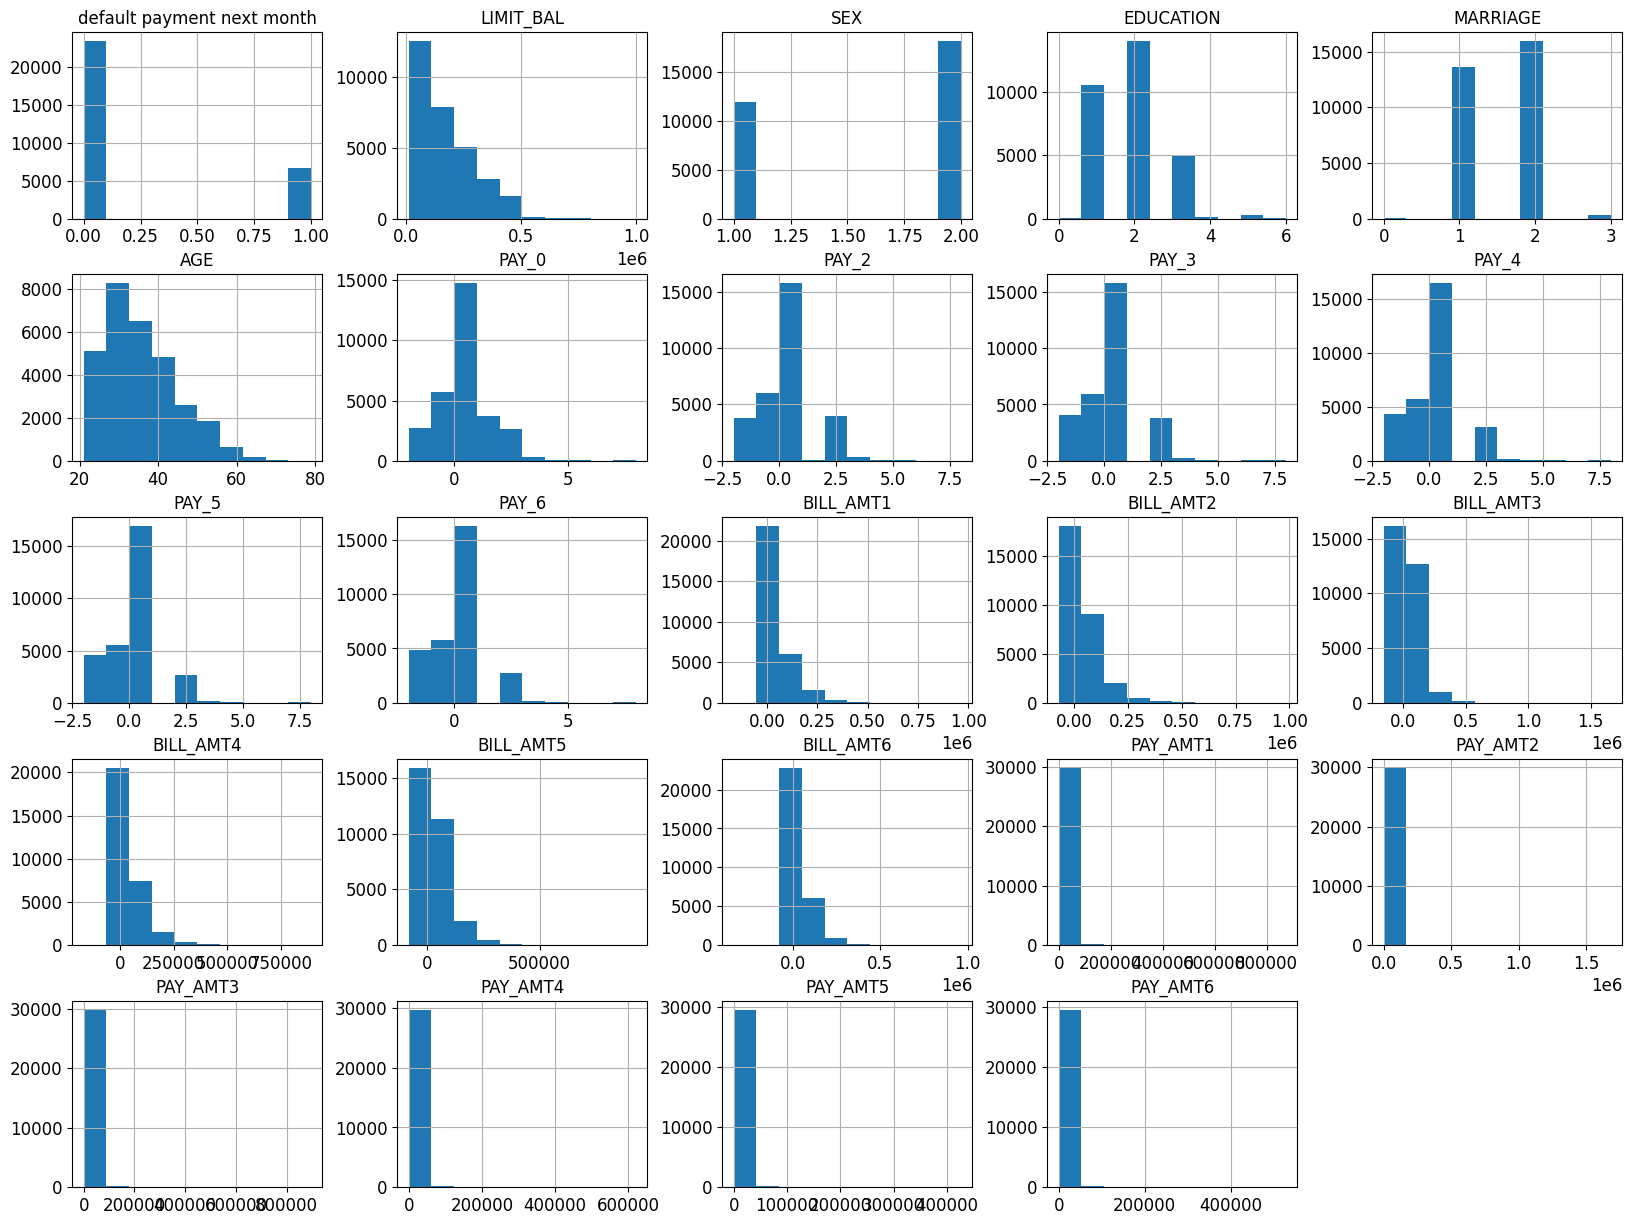

In [ ]:
# plot the histgram to see the data distribution
_ = df_explore.hist(figsize=(20,15))

In [ ]:
# plot the correlation plot to see whether correlation among all the features and default payment next month
rs = np.random.RandomState(123)
df = pd.DataFrame(rs.rand(10, 10))
corr = df_explore.corr()
corr.style.background_gradient(cmap='coolwarm')

,default payment next month,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
default payment next month,1.000000,-0.153520,-0.039961,0.028006,-0.024339,0.013890,0.324794,0.263551,0.235253,0.216614,0.204149,0.186866,-0.019644,-0.014193,-0.014076,-0.010156,-0.006760,-0.005372,-0.072929,-0.058579,-0.056250,-0.056827,-0.055124,-0.053183
LIMIT_BAL,-0.153520,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,-0.235195,0.285430,0.278314,0.283236,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595
SEX,-0.039961,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,-0.044008,-0.033642,-0.031183,-0.024563,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766
EDUCATION,0.028006,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,0.082316,0.023581,0.018749,0.013002,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200
MARRIAGE,-0.024339,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,0.034345,-0.023472,-0.021602,-0.024909,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641
AGE,0.013890,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,-0.048773,0.056239,0.054283,0.053710,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478
PAY_0,0.324794,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,0.474553,0.187068,0.189859,0.179785,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673
PAY_2,0.263551,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,0.575501,0.234887,0.235257,0.224146,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500
PAY_3,0.235253,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,0.632684,0.208473,0.237295,0.227494,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861
PAY_4,0.216614,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,0.716449,0.202812,0.225816,0.244983,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565


# 2. Data Preprocessing:

should identify the categorical and numerical features. I think all the features should be included in the model even though I didn't see any strong correlation in last step, but all the features seem to be related to the probability of default payment.



In [ ]:
# Identify the categorical and numerical features and set the target and predictors
TARGET = "default payment next month"
columns_predictors = [col for col in df_explore.columns if col not in [TARGET]]
columns_categorical = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical = [col for col in columns_predictors if col not in columns_categorical]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: default payment next month
columns_predictors: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
columns_categorical: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [ ]:
# Define X and y
X = df_explore[columns_predictors]
y = df_explore[TARGET]
display(X)
display(y)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,3502,8979,5190,0,1837,3526,8998,129,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,2758,20878,20582,19357,0,0,22000,4200,2000,3100


ID
1        1
2        1
3        0
4        0
5        0
        ..
29996    0
29997    0
29998    1
29999    1
30000    1
Name: default payment next month, Length: 30000, dtype: int64

In [ ]:
# Transform the data
from sklearn.pipeline import Pipeline #each pipeline can have multiple steps
from sklearn.compose import ColumnTransformer #for selecting specific columns and transforming them with individual pipelines
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder #specific transformations we want to use in our pipelines

pipeline_categorical = Pipeline([
  ('onehot', OneHotEncoder(handle_unknown="ignore")),
])

pipeline_numerical = Pipeline([
  ('scaler', MinMaxScaler(feature_range=(0,1))),
])

pipeline_full = ColumnTransformer([
  ("categorical", pipeline_categorical, columns_categorical),
  ("numerical", pipeline_numerical, columns_numerical),
])

pipeline_full

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                  'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                  'PAY_6']),
                                ('numerical',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6'])])

In [ ]:
# Train-test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (24000, 23)
X_test.shape: (6000, 23)
y_train.shape: (24000,)
y_test.shape: (6000,)


In [ ]:
# fit the model and check the shape
pipeline_full.fit(X_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

X_train_transformed.shape: (24000, 91)
X_test_transformed.shape: (6000, 91)


In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

# Train model
model = LogisticRegression(n_jobs=-1, random_state=123)
model.fit(X_train_transformed, y_train)

CPU times: user 54.8 ms, sys: 54.8 ms, total: 110 ms
Wall time: 1.49 s


LogisticRegression(n_jobs=-1, random_state=123)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Evaluate the model
y_pred = model.predict(X_test_transformed)
y_pred_proba = model.predict_proba(X_test_transformed)

print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"precision_score: {precision_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
print(f"f1_score: {f1_score(y_test, y_pred)}")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_proba[:,1])}")

accuracy_score: 0.8206666666666667
precision_score: 0.6881559220389805
recall_score: 0.3458929917106255
f1_score: 0.4603811434302908
roc_auc_score: 0.7730962119285523


In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation with 5-folds
scores = cross_val_score(model, X, np.ravel(y), cv=5, scoring='neg_mean_squared_error')
np.sqrt(-scores)

array([0.47046077, 0.47063787, 0.4702836 , 0.4702836 , 0.4708149 ])

# 3. Classification:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define a function to perform GridSearchCV
def grid_search_classifier(classifier, param_grid, cv):
    grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X_train_transformed, y_train)
    return grid_search

In [ ]:
# Define parameter grids for Random Forest and KNN classifiers
param_grid_rf = {'n_estimators': [4, 5, 10, 20, 50]}
param_grid_knn = {'n_neighbors': [3, 5, 10, 20]}

# Initialize classifiers
rf_classifier = RandomForestClassifier(random_state=123)
knn_classifier = KNeighborsClassifier()

# Perform GridSearchCV for Random Forest
rf_grid_search = grid_search_classifier(rf_classifier, param_grid_rf, cv=5)

# Perform GridSearchCV for KNN
knn_grid_search = grid_search_classifier(knn_classifier, param_grid_knn, cv=5)

# Get the best hyperparameters
best_rf_params = rf_grid_search.best_params_
best_knn_params = knn_grid_search.best_params_

# Fit the best models
best_rf_model = rf_grid_search.best_estimator_
best_knn_model = knn_grid_search.best_estimator_

# Predict probabilities for the positive class (class 1) for both classifiers
rf_probs = best_rf_model.predict_proba(X_test_transformed)[:, 1]
knn_probs = best_knn_model.predict_proba(X_test_transformed)[:, 1]

0.26
0.694747930084429


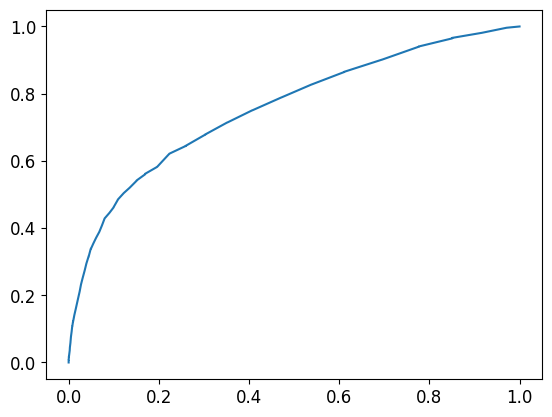

In [ ]:
# find the thresholds for rf
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test,rf_probs)
plt.plot(rf_fpr,rf_tpr)
rf_gmeans = np.sqrt(rf_tpr*(1-rf_fpr))
print(rf_thresholds[np.argmax(rf_gmeans)])
print(rf_gmeans[np.argmax(rf_gmeans)])

0.25
0.6809158247854284


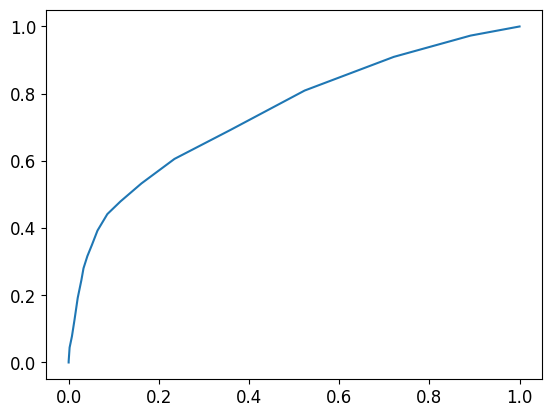

In [ ]:
# find the thresholds for knn
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test,knn_probs)
plt.plot(knn_fpr,knn_tpr)
knn_gmeans = np.sqrt(knn_tpr*(1-knn_fpr))
print(knn_thresholds[np.argmax(knn_gmeans)])
print(knn_gmeans[np.argmax(knn_gmeans)])

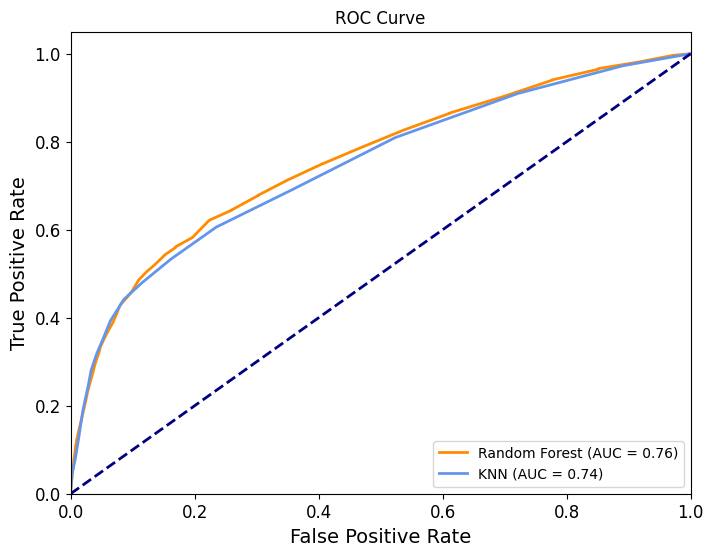

In [ ]:
# Calculate ROC AUC scores for both classifiers before deciding a threshold
rf_auc = roc_auc_score(y_test, rf_probs)
knn_auc = roc_auc_score(y_test, knn_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(fpr_knn, tpr_knn, color='cornflowerblue', lw=2, label=f'KNN (AUC = {knn_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Decide a threshold
threshold = 0.25

# Apply the threshold to make binary predictions
rf_preds = (rf_probs >= threshold).astype(int)
knn_preds = (knn_probs >= threshold).astype(int)

# Evaluate the models with the chosen threshold
rf_roc = roc_auc_score(y_test, rf_preds)
knn_roc = roc_auc_score(y_test, knn_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)
knn_accuracy = accuracy_score(y_test, knn_preds)

print(f"Random Forest ROC AUC Score (Threshold {threshold}): {rf_roc:.2f}")
print(f"KNN ROC AUC Score (Threshold {threshold}): {knn_roc:.2f}")
print()
print(f"Random Forest Accuracy (Threshold {threshold}): {rf_accuracy:.2f}")
print(f"KNN Accuracy (Threshold {threshold}): {knn_accuracy:.2f}")

Random Forest ROC AUC Score (Threshold 0.25): 0.70
KNN ROC AUC Score (Threshold 0.25): 0.69

Random Forest Accuracy (Threshold 0.25): 0.74
KNN Accuracy (Threshold 0.25): 0.73


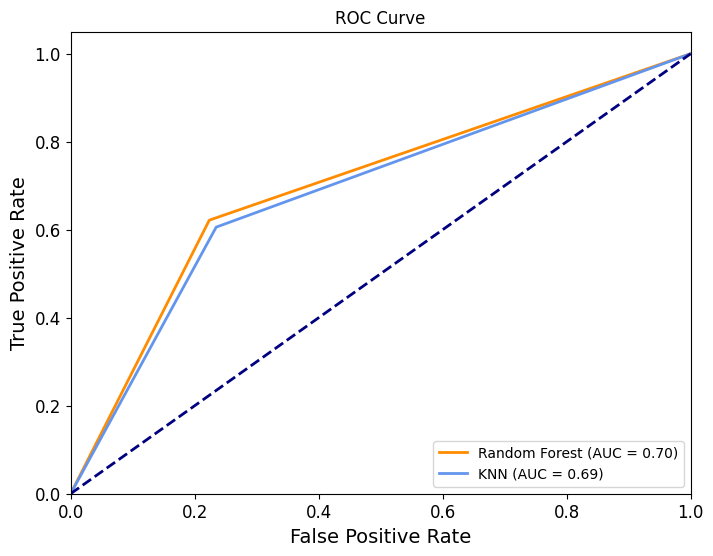

In [ ]:
# Calculate ROC AUC scores for both classifiers with the decided threshold
rf_auc = roc_auc_score(y_test, rf_preds)
knn_auc = roc_auc_score(y_test, knn_preds)

# Plot ROC curves
plt.figure(figsize=(8, 6))
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_preds)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_preds)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(fpr_knn, tpr_knn, color='cornflowerblue', lw=2, label=f'KNN (AUC = {knn_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# **Conclusions**

The classifier whose ROC curve is closer to top-left corner is better. This is also reflected in a better ROC AUC score (close to 1). Therefore, The **Random Forest classifier** outperforms the KNN classifier based on the graphs. Also, Random Forest has higher ROC AUC score and accuracy score.

